In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy.integrate import odeint
from numpy import linalg as LA

mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 20

%matplotlib inline

# Better looking figures
%config InlineBackend.figure_format = 'retina'

# Make cells narrower for better typography
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))

In [8]:
def constants(m1, m2, m3, a_i, a_o, e_i, e_o):
    """
    Calculates constants to be used for plotting the Hamiltonian.
    
    
    This function returns various constants in specified units
    which are then used to construct a phase-space plot of the Hamiltonian.
    
    Parameters
    ----------
    m1 : float
        Mass of star1 in units of solar masses.
    m2 : float
        Mass of star2 in units of solar masses.
    m3 : float
        Mass of star3 in units of solar masses.
    a_i : float
        Semi-major axis of inner binary in units au. 
    a_o : float
        Semi-major axis of outer binary in units au.
    e_i : float
        Eccentricity of the inner binary.
    e_o : float
        Eccentricity of the outer binary.
        
    Returns
    -------
    mu_i: float
        The inner mass mass ratio.
    Lambda_i: float
        The inner Poincare momentum at nominal resonance location.
    Lambda_o: float
        The outer Poincare momentum at nominal resonance location.
    Gamma_i: float
        The inner Poincare momentum at nominal resonance location.
    Gamma_o: float
        The inner Poincare momentum at nominal resonance location.    
    alpha: float
        The alpha parameter in the Hamiltonian at the nominal resonance
        location.
    beta: float
        The Beta parameter in the Hamiltonian at the nominal resonance
        location. 
    eps: 
        The epsilon parameter in the Hamiltonian.
    delta:
        The delta parameter in the Hamiltonian.
        
    """
    # Change mass units
    m1 = m1/m12
    m2 = m2/m12
    m3 = m3/m12
    
    # Change semi-major axis units
    a_o = a_o/a_i
    a_i = 1 # by definition at resonance location
    
    # Mass factors
    mu_i = m1*m2
    
    # Poincaré momenta
    Lambda_i = mu_i*np.sqrt(a_i)
    Lambda_o = m3*np.sqrt(a_o)
    Gamma_i = Lambda_i*(1 - np.sqrt(1 - e_i**2))
    Gamma_o = Lambda_o*(1 - np.sqrt(1 - e_o**2))
        
    # Constants
    Theta3 = Gamma_i - Gamma_o/4 
    alpha = 54*m3**3/Lambda_o**4 + 3*mu_i**3/(2*Lambda_i**4)
    beta =  3*m3**3/Lambda_o**3 - mu_i**3/(2*Lambda_i**3)
    delta = 4*beta/alpha
    
    eps = (np.sqrt(Theta3)/alpha)*(4797*np.sqrt(2)/16)*Lambda_i**(7/2)*m3**7\
        /(Lambda_o**8*mu_i**3)
    
    return mu_i, Lambda_o, Lambda_i, Gamma_o, Gamma_i, alpha, beta, eps, delta
    

# Initial conditions, these parameters are all CONSTANTS, defined at nominal resonance
# location. The units here are au, msun and years

m1 = 1. # in solar masses
m2 = .7
m3 = 1e-03
m12 = m1 + m2

period_to_a = lambda P, M: (P**2*M)**(1/3.)

P_i = 41/365 # in years
P_o = 6.0*P_i # 6:1 commensurability

a_i = period_to_a(P_i, m12) # in au
a_o = period_to_a(P_o, m12)

e_i = .3
e_o = .1

# Calculate constants for use in the Hamiltonian
mu_i, Lambda_o, Lambda_i, Gamma_o,\
Gamma_i, alpha, beta, eps, delta_init = constants(m1, m2, m3, a_i, a_o, e_i, e_o)

# if not (beta < 1e-05):
#         raise AssertionError("Beta should be approx. zero if at period commensurability,\
#                              are you sure you entered the right parameters?")

print("mu_i: ", mu_i)
print("m3: ", m3)
print("Lambda_i: ", Lambda_i)
print("Lambda_o: ", Lambda_o)
print("beta: ", beta)
print("epsilon: ", eps)
print("delta: ", delta_init/1e-04)

# Calculate sensible range od delta
# delta_range = np.zeros(10)
# P_o_range = np.linspace(5.7*P_i, 6.3*P_i, 10)

# for i, outer_period in enumerate(P_test):
#     a_test = period_to_a(outer_period, m12)
#     t1, t2, t3, t4, t5, t6, beta_,eps_, delta_ = constants(m1, m2, m3, a_i, a_test, e_i, e_o)
#     delta_range[i] = delta_
    
# plt.plot(P_o_range/P_i, delta_range)
# print(delta_range)

mu_i:  0.2422145328719723
m3:  0.001
Lambda_i:  0.242214532872
Lambda_o:  0.00106889446637
beta:  1.11022302463e-16
epsilon:  0.0374073138108
delta:  5.27039582852e-16


# Time evolution of Hamiltonian

Initial Theta:  1.33947518477e-06
Initial theta:  1.325364209718693
Initial delta:  0.1


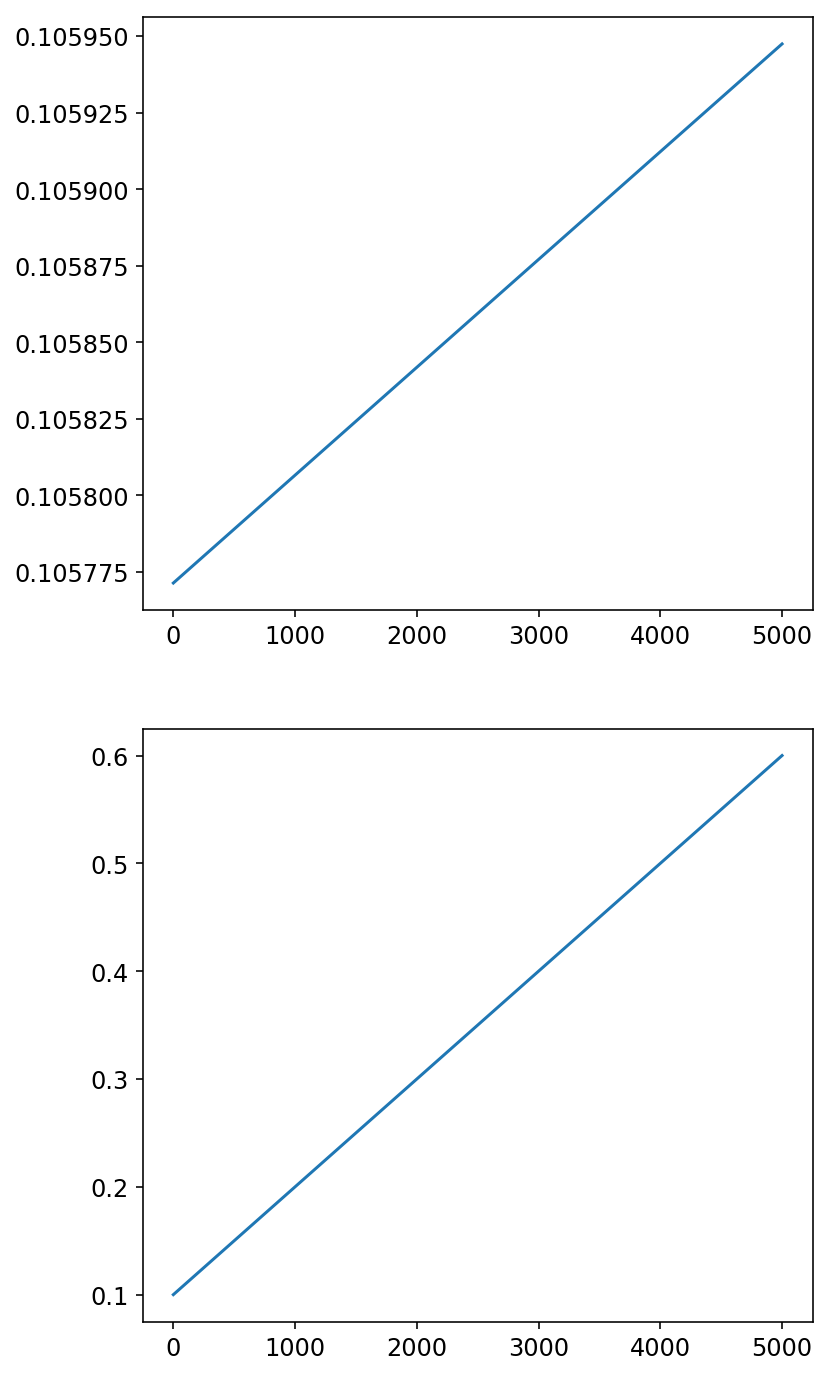

In [16]:
def time_evolution(var, t, params):
    """
    Defines the differential equations for the time evolution of the 
    resonant Hamiltonian
    
    Arguments:
        var :  vector of the state variables:
                  var = [Phi, phi, delta]
        t :  time
        params :  vector of the parameters:
                  params = [eps, delta_dot, alpha]
    """
    Theta, theta, delta = var # updated each timestep
    
    eps, delta_dot, alpha = params
    
    # Calculate derivatives    
    f = np.array([
        -16*eps*Phi**2*np.sin(4*phi),
        2*Phi - delta + 8*eps*Phi*np.cos(4*phi),
        delta_dot
    ])
    
    return f


delta_dot = 1e-4

# Initial conditions 
Phi = Gamma_o/4
phi = np.random.rand()*2*np.pi
delta = 0.1

print("Initial Theta: ", Phi)
print("Initial theta: ", phi)
print("Initial delta: ", delta)

# ODE solver parameters
# abserr = 1.0e-8
# relerr = 1.0e-6

# Time grid
t = np.linspace(0, 5e03, 200000)

params = np.array([eps, delta_dot, alpha])
var = np.array([Phi, phi, delta])

# Call the ODE solver.
sol = odeint(time_evolution, var, t, args=(params,), full_output=0)

ecc = np.sqrt(8*sol[:, 0]/(m3*np.sqrt(a_o)))
d = sol[:, 2]

fig, ax = plt.subplots(2, figsize=(6,12))
ax[0].plot(t, ecc)
ax[1].plot(t, d)